In [1]:

#!/usr/bin/env python
# -*- coding: utf-8 -*-

'''
STDP modulated with reward

Adapted from Fig. 1c of:
Eugene M. Izhikevich 
Solving the distal reward problem through linkage of STDP and dopamine signaling. 
Cerebral cortex 17, no. 10 (2007): 2443-2452.

Note:
The variable "mode" can switch the behavior of the synapse from "Classical STDP" to "Dopamine modulated STDP".

Author: Guillaume Dumas (Institut Pasteur)
Date: 2018-08-24
'''
import matplotlib.pyplot as plt
from brian2 import *
start_scope()

"""Parameters"""
simulation_duration = 1000 * second

# Neuron parameters
numberNeuronGroups = 5
neuronGroupSize = 20
taum = 10*ms
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms

# STDP parameters
taupre = 20*ms
taupost = taupre
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

# Dopamine signaling parameters
tauc = 1000*ms
taud = 200*ms
taus = 1*ms
epsilon_dopa = 5e-3

"""Initialize a network"""
network = Network()


"""Stimulus section"""

# Defining the stimuli
input_times = np.array([200*i + np.random.uniform(-50., 50.) for i in range(1,int(simulation_duration/0.2)+1)])*ms # define when the stimuli happen - we divide the simulation duration (in seconds) by the step: 0.2 seconds
input_indices = np.array([np.random.randint(0, numberNeuronGroups) for i in range(1,int(simulation_duration/0.2)+1)]) # define which group each pulse targets
groupedStimuli = SpikeGeneratorGroup(numberNeuronGroups,input_indices, input_times)
network.add(groupedStimuli)

noise_rate = 1*Hz
noise = PoissonGroup(numberNeuronGroups*neuronGroupSize, noise_rate)
network.add(noise)

# Defining the corresponding neurons
neurons = NeuronGroup(numberNeuronGroups*neuronGroupSize,  '''dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
                                      dge/dt = -ge / taue : 1''',
                      threshold='v>vt', reset='v = vr',
                      method='linear')
neurons.v = vr
network.add(neurons)

inputSynapse = Synapses(groupedStimuli, neurons, model='''s : volt''', on_pre='v += s') # every time an input fires the corresponding neurons are depolarized beyond threshold
for k in range(numberNeuronGroups):
       inputSynapse.connect(i=[k], j=list(range(neuronGroupSize*k + 1, neuronGroupSize*(k+1)))) # input i is connected to all the neurons in the group Si
inputSynapse.s = 100*mV

noiseSynapse = Synapses(noise, neurons, model='''s : volt''', on_pre='v += s')
noiseSynapse.connect(condition = 'i==j', p = 1.)
noiseSynapse.s = 100*mV


# The synapse is ready to add !
network.add(inputSynapse)
network.add(noiseSynapse)


"""STDP section"""
epsilon = 0.1 # sparseness of synaptic connections

synapse_stdp = Synapses(neurons, neurons,
                   model='''mode: 1
                         dc/dt = -c / tauc : 1 (clock-driven)
                         dd/dt = -d / taud : 1 (clock-driven)
                         ds/dt = mode * c * d / taus : 1 (clock-driven)
                         dApre/dt = -Apre / taupre : 1 (event-driven)
                         dApost/dt = -Apost / taupost : 1 (event-driven)''',
                   on_pre='''ge += s
                          Apre += dApre
                          c = clip(c + mode * Apost, -gmax, gmax)
                          s = clip(s + (1-mode) * Apost, -gmax, gmax)
                          ''',
                   on_post='''Apost += dApost
                          c = clip(c + mode * Apre, -gmax, gmax)
                          s = clip(s + (1-mode) * Apre, -gmax, gmax)
                          ''',
                   method='euler'
                   )


# Connectivity: make sure a neuron does not form a synapse with itself
synapse_stdp.connect(condition = 'i!=j', p=epsilon)

# Initialize the parameters of the synapses
synapse_stdp.mode = 0
synapse_stdp.s = 1e-10
synapse_stdp.c = 1e-10
synapse_stdp.d = 0

# The synapse is ready to add !
network.add(synapse_stdp)

"""Dopamine signaling section"""

dopamine = NeuronGroup(1, '''v : volt''', threshold='v>1*volt', reset='v=0*volt')
network.add(dopamine)

# To monitor when dopamine is released
dopamine_monitor = SpikeMonitor(dopamine)
network.add(dopamine_monitor)


# Synapse ordering dopamine release when the conditioning stimulus occurs
conditioning = Synapses(groupedStimuli, dopamine, on_pre='''v_post += 2*volt''', method='exact') # 2*volt is bigger than the dopamine neuron's 1*volt threshold
conditioning.connect(i  = 0, j = 0)
network.add(conditioning)

# Synapse that accounts for the effect of dopamine on plasticity
reward = Synapses(dopamine, synapse_stdp, on_pre='''d_post += epsilon_dopa''', method='exact')
reward.connect(p=1.) # every synapse is affected by dopamine
reward.delay='100*ms' # dopamine reaches the synapse 100ms after the conditioning stimulus

# The synapse is ready to add !
network.add(reward)

# Simulation
## Classical STDP
#synapse_stdp.mode = 0

## Dopamine modulated STDP
synapse_stdp.mode = 1
neuronSpikes = SpikeMonitor(neurons, record=True)
network.add(neuronSpikes)
network.run(simulation_duration, report='text')

WARNING    /Users/js/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/js/Library/Caches/cython/brian_extensions/_cython_magic_3df38c0a673201e24981407558d558cf.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    /Users/js/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/js/Library/Caches/cython/brian_extensions/_cython_magic_720ad049877ee556d83f634ee4e6280b.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    /Users/js/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/js/Library/Caches/cytho

Starting simulation at t=0. s for a duration of 1. ks
5.9526 (0%) simulated in 10s, estimated 27m 50s remaining.
12.8934 (1%) simulated in 20s, estimated 25m 31s remaining.
19.843500000000002 (1%) simulated in 30s, estimated 24m 42s remaining.
26.4145 (2%) simulated in 40s, estimated 24m 34s remaining.
33.644800000000004 (3%) simulated in 50s, estimated 23m 56s remaining.
41.0709 (4%) simulated in 1m 0s, estimated 23m 21s remaining.
48.529 (4%) simulated in 1m 10s, estimated 22m 52s remaining.
55.3232 (5%) simulated in 1m 20s, estimated 22m 46s remaining.
62.2077 (6%) simulated in 1m 30s, estimated 22m 37s remaining.
69.0771 (6%) simulated in 1m 40s, estimated 22m 28s remaining.
75.2337 (7%) simulated in 1m 50s, estimated 22m 32s remaining.
81.8636 (8%) simulated in 2m 0s, estimated 22m 26s remaining.
88.6918 (8%) simulated in 2m 10s, estimated 22m 16s remaining.
95.8781 (9%) simulated in 2m 20s, estimated 22m 0s remaining.
102.8468 (10%) simulated in 2m 30s, estimated 21m 48s remainin

776.9574 (77%) simulated in 20m 20s, estimated 5m 50s remaining.
783.3448000000001 (78%) simulated in 20m 30s, estimated 5m 40s remaining.
789.9530000000001 (78%) simulated in 20m 40s, estimated 5m 30s remaining.
796.5188 (79%) simulated in 20m 50s, estimated 5m 19s remaining.
803.0178000000001 (80%) simulated in 21m 0s, estimated 5m 9s remaining.
809.5666 (80%) simulated in 21m 10s, estimated 4m 59s remaining.
816.1017 (81%) simulated in 21m 20s, estimated 4m 48s remaining.
822.3903 (82%) simulated in 21m 30s, estimated 4m 39s remaining.
828.9041000000001 (82%) simulated in 21m 40s, estimated 4m 28s remaining.
834.7973000000001 (83%) simulated in 21m 50s, estimated 4m 19s remaining.
841.1137 (84%) simulated in 22m 0s, estimated 4m 9s remaining.
847.4411 (84%) simulated in 22m 10s, estimated 3m 59s remaining.
853.6317 (85%) simulated in 22m 20s, estimated 3m 50s remaining.
859.4294 (85%) simulated in 22m 30s, estimated 3m 41s remaining.
866.5041 (86%) simulated in 22m 40s, estimated 3m

<IPython.core.display.Javascript object>


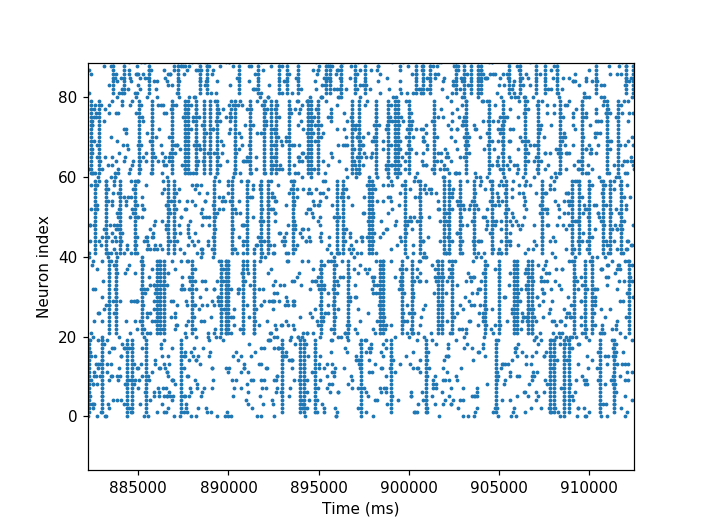

In [2]:
%matplotlib notebook
plt.plot(neuronSpikes.t/ms, neuronSpikes.i, '.', markersize=3)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.savefig('raster')

In [3]:
tab = []
for t0 in input_times/ms:
    tab.append(len([t for t in neuronSpikes.t/ms if t>= t0 and t < t0+50]))
tab

[26,
 24,
 27,
 25,
 23,
 22,
 23,
 25,
 29,
 24,
 24,
 23,
 24,
 25,
 30,
 23,
 21,
 26,
 25,
 26,
 21,
 26,
 26,
 23,
 25,
 26,
 21,
 23,
 25,
 22,
 22,
 24,
 26,
 25,
 24,
 23,
 23,
 25,
 22,
 23,
 21,
 24,
 22,
 24,
 27,
 23,
 23,
 20,
 22,
 24,
 21,
 23,
 24,
 27,
 23,
 25,
 25,
 23,
 26,
 21,
 23,
 24,
 26,
 23,
 24,
 21,
 22,
 24,
 26,
 26,
 22,
 25,
 23,
 23,
 26,
 27,
 22,
 22,
 24,
 23,
 26,
 25,
 26,
 22,
 22,
 23,
 23,
 23,
 26,
 26,
 25,
 29,
 26,
 19,
 25,
 24,
 23,
 25,
 23,
 27,
 22,
 24,
 25,
 24,
 24,
 26,
 25,
 24,
 20,
 20,
 26,
 21,
 24,
 24,
 26,
 23,
 24,
 23,
 23,
 24,
 29,
 25,
 25,
 26,
 22,
 25,
 24,
 22,
 23,
 23,
 21,
 27,
 21,
 23,
 24,
 23,
 23,
 25,
 22,
 26,
 24,
 27,
 24,
 22,
 25,
 23,
 25,
 23,
 26,
 26,
 25,
 23,
 27,
 25,
 24,
 26,
 23,
 26,
 20,
 24,
 28,
 26,
 22,
 21,
 21,
 24,
 22,
 22,
 22,
 21,
 25,
 23,
 22,
 28,
 28,
 26,
 22,
 24,
 26,
 25,
 22,
 27,
 22,
 26,
 21,
 22,
 24,
 21,
 21,
 23,
 22,
 23,
 20,
 22,
 23,
 24,
 22,
 23,
 27,
 22,
